## Tidal Model

This model represents highlands bordered by a tidal estuary.  The model
has 3 layers representing an upper aquifer, confining bed, and lower aquifer.
The grid is 15 rows by 10 columns.  The length unit is feet and the time unit
is days. Each cell is 500 ft x 500 ft.  The estuary is represented by GHB
boundaries in column 10.  Two rivers cross the area from left to right.
Recharge is zoned by the use of three Recharge-Package input files

### Initial setup

Import dependencies, read settings from environment variables, and define model parameters.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
import pooch
from flopy.plot.styles import styles
from flopy.utils.gridintersect import GridIntersect
from modflow_devtools.misc import get_env, timed
from shapely.geometry import Polygon

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-advtidal"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 4  # Number of periods
nlay = 3  # Number of layers
ncol = 10  # Number of columns
nrow = 15  # Number of rows
delr = 500.0  # Column width ($m$)
delc = 500.0  # Row width ($m$)
top = 50.0  # Top of the model ($m$)
botm_str = "5.0, -10.0, -100.0"  # Layer bottom elevations ($m$)
strt = 50.0  # Starting head ($m$)
icelltype_str = "1, 0, 0"  # Cell conversion type
k11_str = "5.0, 0.1, 4.0"  # Horizontal hydraulic conductivity ($m/d$)
k33_str = "0.5, 5.0e-3, 0.1"  # Vertical hydraulic conductivity ($m/d$)
ss = 1.0e-6  # Specific storage ($/m$)
sy = 0.2  # Specific yield (unitless)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)
# and 3 transient stress periods (10 days each).
# Each transient stress period has 120 2-hour time steps.
perlen = [1.0, 10.0, 10.0, 10.0]
nstp = [1, 120, 120, 120]
tsmult = [1.0, 1.0, 1.0, 1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# Parse parameter strings into tuples
botm = [float(value) for value in botm_str.split(",")]
k11 = [float(value) for value in k11_str.split(",")]
k33 = [float(value) for value in k33_str.split(",")]
icelltype = [int(value) for value in icelltype_str.split(",")]

# Recharge zones (constructed with shapely)
recharge_zone_1 = Polygon(
    shell=[(0, 0), (3000, 0), (3000, 5500), (1000, 7500), (0, 7500), (0, 0)]
)
recharge_zone_2 = Polygon(
    shell=[(1000, 7500), (3000, 5500), (5000, 7500), (1000, 7500)]
)
recharge_zone_3 = Polygon(
    shell=[(3000, 0), (5000, 0), (5000, 7500), (3000, 5500), (3000, 0)]
)

# Solver parameters
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def get_timeseries(fname, names, interpolation, filename=None):
    tsdata = []
    for row in np.genfromtxt(fname, delimiter=",", comments="#"):
        tsdata.append(tuple(row))
    tsdict = {
        "timeseries": tsdata,
        "time_series_namerecord": names,
        "interpolation_methodrecord": interpolation,
    }
    if filename is not None:
        tsdict["filename"] = filename
    return tsdict


def build_models():
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(
        sim_name=sim_name,
        sim_ws=sim_ws,
        exe_name="mf6",
        verbosity_level=0,
    )
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        cvoptions="perched",
        perched=True,
        icelltype=icelltype,
        k=k11,
        k33=k33,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfsto(
        gwf,
        iconvert=1,
        ss=1.0e-6,
        sy=sy,
        steady_state={0: True},
        transient={1: True},
    )

    ghb_spd = []
    ghb_spd += [[1, i, 9, "tides", 15.0, "ESTUARY-L2"] for i in range(nrow)]
    ghb_spd += [[2, i, 9, "tides", 1500.0, "ESTUARY-L3"] for i in range(nrow)]
    ghb_spd = {0: ghb_spd}
    fname = "tides.csv"
    fname = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:425337a0bf24fa72c9e40f4e3d9f698a",
    )
    tsdict = get_timeseries(fname, "tides", "linear")
    ghbobs_dict = {}
    ghbobs_dict[f"{sim_name}.ghb.obs.csv"] = [
        ("ghb_2_6_10", "ghb", (1, 5, 9)),
        ("ghb_3_6_10", "ghb", (2, 5, 9)),
        ("estuary2", "ghb", "ESTUARY-L2"),
        ("estuary3", "ghb", "ESTUARY-L3"),
    ]

    flopy.mf6.ModflowGwfghb(
        gwf,
        stress_period_data=ghb_spd,
        boundnames=True,
        timeseries=tsdict,
        observations=ghbobs_dict,
        pname="GHB-TIDAL",
    )

    wel_spd = {}
    wel_spd[1] = [
        [0, 11, 2, -50, ""],
        [2, 4, 7, "well_1_rate", "well_1"],
        [2, 3, 2, "well_2_rate", "well_2"],
    ]
    wel_spd[2] = [
        [2, 3, 2, "well_2_rate", "well_2"],
        [2, 4, 7, "well_1_rate", "well_1"],
    ]
    wel_spd[3] = [
        [2, 4, 7, "well_1_rate", "well_1"],
        [2, 3, 2, "well_2_rate", "well_2"],
        [0, 11, 2, -10, ""],
        [0, 2, 4, -20, ""],
        [0, 13, 5, -40, ""],
    ]
    fname = "wellrates.csv"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:6ca7366be279d679b14e8338a195422f",
    )
    tsdict = get_timeseries(
        fpath, ["well_1_rate", "well_2_rate", "well_6_rate"], 3 * ["stepwise"]
    )
    flopy.mf6.ModflowGwfwel(
        gwf,
        stress_period_data=wel_spd,
        boundnames=True,
        timeseries=tsdict,
        pname="WEL",
    )

    rivlay = 20 * [0]
    rivrow = [2, 3, 4, 4, 5, 5, 5, 4, 4, 4, 9, 8, 7, 6, 6, 5, 5, 6, 6, 6]
    rivcol = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    rivstg = 10 * ["river_stage_1"] + 10 * ["river_stage_2"]
    rivcnd = 2 * [1000 + f + 1 for f in range(10)]
    rivrbt = list(np.linspace(35.9, 35.0, 10)) + list(np.linspace(36.9, 36.0, 10))
    rivbnd = (
        5 * [""]
        + ["riv1_c6", "riv1_c7"]
        + 3 * [""]
        + 3 * ["riv2_upper"]
        + 2 * [""]
        + ["riv2_c6", "riv2_c7"]
        + 3 * [""]
    )
    riv_spd = list(zip(rivlay, rivrow, rivcol, rivstg, rivcnd, rivrbt, rivbnd))
    fname = "riverstage.csv"
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
        fname=fname,
        path=data_path,
        known_hash="md5:83f8b526ec6e6978b1d9dbd6fde231ef",
    )
    tsdict = get_timeseries(
        fpath,
        ["river_stage_1", "river_stage_2"],
        ["linear", "stepwise"],
    )
    flopy.mf6.ModflowGwfriv(
        gwf,
        stress_period_data=riv_spd,
        boundnames=True,
        timeseries=tsdict,
        pname="RIV",
    )

    hashes = [
        "f8b9b26a3403101f3568cd42f759554f",
        "c1ea7ded8edf33d6d70a1daf2524584a",
        "9ca294d3260c9d3c3487f8db498a0aa6",
    ]
    for ipak, p in enumerate([recharge_zone_1, recharge_zone_2, recharge_zone_3]):
        ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)
        result = ix.intersect(p)
        rch_spd = []
        for i in range(result.shape[0]):
            rch_spd.append(
                [
                    0,
                    *result["cellids"][i],
                    f"rch_{ipak + 1}",
                    result["areas"][i] / delr / delc,
                ]
            )
        fname = f"recharge{ipak + 1}.csv"
        fpath = pooch.retrieve(
            url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
            fname=fname,
            path=data_path,
            known_hash=f"md5:{hashes[ipak]}",
        )
        tsdict = get_timeseries(
            fpath,
            [f"rch_{ipak + 1}"],
            ["stepwise"],
            filename=f"{sim_name}.rch{ipak + 1}.ts",
        )
        flopy.mf6.ModflowGwfrch(
            gwf,
            stress_period_data=rch_spd,
            boundnames=True,
            timeseries=tsdict,
            fixed_cell=True,
            print_input=True,
            print_flows=True,
            save_flows=True,
            auxiliary=["MULTIPLIER"],
            auxmultname="MULTIPLIER",
            pname=f"RCH-ZONE_{ipak + 1}",
            filename=f"{sim_name}.rch{ipak + 1}",
        )

    nseg = 3
    etsurf = 50
    etrate = 0.0004
    depth = 10.0
    pxdp = [0.2, 0.5]
    petm = [0.3, 0.1]
    row, col = np.where(np.zeros((nrow, ncol)) == 0)
    cellids = list(zip(nrow * ncol * [0], row, col))
    evt_spd = [[k, i, j, etsurf, etrate, depth, *pxdp, *petm] for k, i, j in cellids]
    flopy.mf6.ModflowGwfevt(gwf, nseg=nseg, stress_period_data=evt_spd, pname="EVT")

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    obsdict = {}
    obslist = [["h1_13_8", "head", (2, 12, 7)]]
    obsdict[f"{sim_name}.obs.head.csv"] = obslist
    obslist = [["icf1", "flow-ja-face", (0, 4, 5), (0, 5, 5)]]
    obsdict[f"{sim_name}.obs.flow.csv"] = obslist
    obs = flopy.mf6.ModflowUtlobs(gwf, print_input=False, continuous=obsdict)

    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (4, 4)


def plot_grid(sim):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=(5.5, 8.0))

        ax = fig.add_subplot(2, 2, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        pmv.plot_bc(name="WEL", kper=3)
        pmv.plot_bc(name="RIV")
        title = "Layer 1"
        letter = chr(ord("@") + 1)
        styles.heading(letter=letter, heading=title, ax=ax)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        ax = fig.add_subplot(2, 2, 2, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=1)
        pmv.plot_grid()
        pmv.plot_bc(name="GHB")
        title = "Layer 2"
        letter = chr(ord("@") + 2)
        styles.heading(letter=letter, heading=title, ax=ax)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        ax = fig.add_subplot(2, 2, 3, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=2)
        pmv.plot_grid()
        pmv.plot_bc(name="GHB")
        pmv.plot_bc(ftype="WEL", kper=3)
        title = "Layer 3"
        letter = chr(ord("@") + 3)
        styles.heading(letter=letter, heading=title, ax=ax)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")

        ax = fig.add_subplot(2, 2, 4, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax)
        pmv.plot_grid(linewidth=0)
        for ip, (p, fc) in enumerate(
            [(recharge_zone_1, "r"), (recharge_zone_2, "b"), (recharge_zone_3, "g")]
        ):
            xs, ys = p.exterior.xy
            ax.fill(
                xs, ys, alpha=0.25, fc=fc, ec="none", label=f"Recharge Zone {ip + 1}"
            )
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.graph_legend(ax)
        title = "Recharge zones"
        letter = chr(ord("@") + 4)
        styles.heading(letter=letter, heading=title, ax=ax)
        if plot_show:
            plt.show
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_ts(sim):
    with styles.USGSMap():
        gwf = sim.get_model(sim_name)
        obsnames = gwf.obs[1].output.obs_names
        obs_list = [
            gwf.obs[1].output.obs(f=obsnames[0]),
            gwf.obs[1].output.obs(f=obsnames[1]),
            gwf.ghb.output.obs(),
        ]
        ylabel = ("head (m)", "flow ($m^3/d$)", "flow ($m^3/d$)")
        obs_fig = ("obs-head", "obs-flow", "ghb-obs")
        for iplot, obstype in enumerate(obs_list):
            fig = plt.figure(figsize=(6, 3))
            ax = fig.add_subplot()
            tsdata = obstype.data
            for name in tsdata.dtype.names[1:]:
                ax.plot(tsdata["totim"], tsdata[name], label=name)
            ax.set_xlabel("time (d)")
            ax.set_ylabel(ylabel[iplot])
            styles.graph_legend(ax)
            if plot_show:
                plt.show()
            if plot_save:
                fpth = figs_path / f"{sim_name}-{obs_fig[iplot]}.png"
                fig.savefig(fpth)


def plot_results(sim, silent=True):
    plot_grid(sim)
    plot_ts(sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

run_models took 532.33 ms


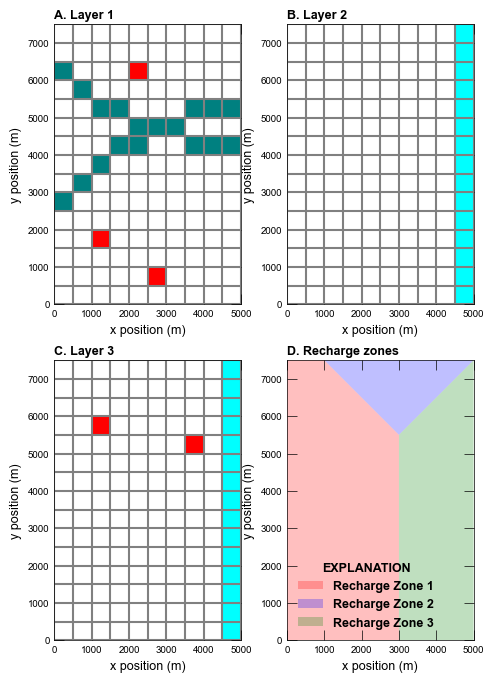

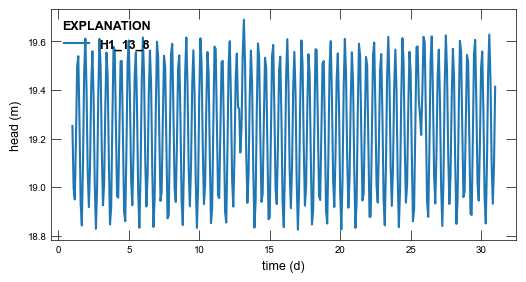

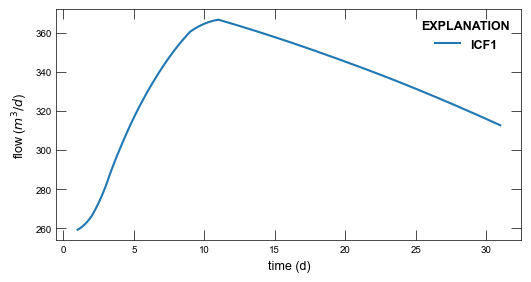

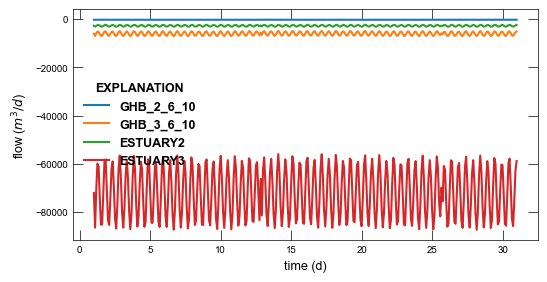

In [5]:
def scenario(silent=True):
    sim = build_models()
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, silent=silent)


scenario()